# API exercises

In [1]:
from datetime import date, datetime, timezone
import asyncio
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

A fast ride through many of the APIs we introduced! Answer below questions to get to know the basics of each API using the [code snippets](https://github.com/JanaLasser/SICSS-aachen-graz/blob/main/02_01_APIs/exercise/API_access_code_snippets.ipynb) we provide for each API. If you get stuck on one task, move on after trying for max 10 min.  

**Note:** You don't have to work on the tasks in sequential order, as they do not depend on each other. Start with the API you are interested in using the most.

## Google trends
When was the maximum for searches for "machine learning" in your country of residence in the last 20 years?

In [ ]:
! pip install pytrends
from pytrends.request import TrendReq
trend_client = TrendReq()

In [3]:
kw_list = ["machine+learning"] # list of keywords we want to get search trends for
timeframe = "today 5-y" # timeframe for which we want to request the trend
geo = "AT" # geographical scope for wich we want to request the trend

trend_client.build_payload(
    kw_list, 
    timeframe=timeframe,
    geo='AT'
)

In [4]:
df = trend_client.interest_over_time()
df.head(2)

,machine+learning,isPartial
date,,
2017-07-23,48,False
2017-07-30,47,False


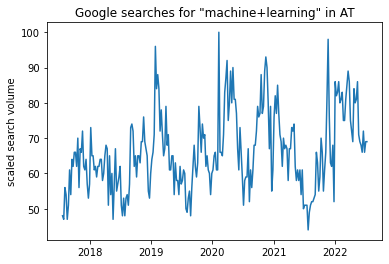

In [5]:
fig, ax = plt.subplots()
kw = kw_list[0]
ax.plot(df.index, df[kw])
ax.set_ylabel("scaled search volume")
ax.set_title(f'Google searches for "{kw}" in {geo}');b

In [13]:
max_date = df[kw].idxmax().date()
print(f"maximum search volume for {kw} occurred on {max_date}")

maximum search volume for machine+learning occurred on 2020-02-09


## Twitter API 
* How many tweets did the account of the president of the United States post in the last 7 days? If you have academic level API access, check the number of tweets for all of 2022. Note: you can solve this exercise both with the "search" and the "counts" endpoint! 
* If you use the full-archive search, how many tweets are returned for a single request? 
* Given Twitter's rate limits for the full-archive search: how long will it take to download a number of tweets equal to your monthly quota (10 mio tweets)?

In [ ]:
! pip install twarc
from twarc import Twarc2

In [16]:
bearer_token = "XXX" # replace the XXX with your bearer token
twarc_client = Twarc2(bearer_token=bearer_token)

In [23]:
# twitter account of Joe Bide: https://twitter.com/JoeBiden?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor
account = "joebiden"
query = f"from: {account}"
start = datetime(2022, 1, 1, 0, 0, 0, 0, tzinfo=timezone.utc)
end = datetime(2022, 7, 18, 0, 0, 0, 0, tzinfo=timezone.utc)

day_counts = []
for c in twarc_client.counts_all(
    query, 
    start_time=start, 
    end_time=end, 
    granularity='day'):
    
    day_counts.extend(c['data'])

In [24]:
# saving the JSON to a file
with open("counts_biden.json", "w") as counts_file:
    json_object = json.dumps(day_counts)
    counts_file.write(json_object)

In [25]:
# reading the JSON file into a pandas DataFrame
df = pd.read_json("counts_biden.json")
df.head(2)

,end,start,tweet_count
0,2022-06-18T00:00:00.000Z,2022-06-17T00:00:00.000Z,5
1,2022-06-19T00:00:00.000Z,2022-06-18T00:00:00.000Z,2


In [30]:
total_counts = df["tweet_count"].sum()
print(f"number of tweets from {account} from {start.date()} to {end.date()}: {total_counts}")

number of tweets from joebiden from 2022-01-01 to 2022-07-18: 482


If you request tweets with context annotations, the maximum number of tweets returned per request is 100. Without context annotations it is 500. 

According to the API [documentation](https://developer.twitter.com/en/docs/twitter-api/rate-limits), the rate limit for the full archive search is 300 requests / 15 min or 1200 requests / hour. If you request Tweets without context annotations at a rate of 500 tweets / request, you can get 500 * 1200 = 600,000 tweets / hour. That means you can max out your monthly quota of 10 mio tweets in 16 hours and 40 minutes. If you request tweets with context annotations, you will need 83 hours and 20 minutes to max out your monthly quota.

## Reddit Pushshift
Which submission in the subreddit "compsocialsci" from **2021** to now had the most comments?

In [ ]:
! pip install psaw 
from psaw import PushshiftAPI

In [8]:
api = PushshiftAPI()

start = int(datetime(2021, 1, 1).timestamp()) 
end = int(datetime(2022, 7, 18).timestamp()) 
subreddit = "compsocialsci" 
filters = ['id', 'author', 'created_utc', 'domain', 'url',
           'title', 'num_comments', 'selftext'] 

posts = list(api.search_submissions(
    subreddit=subreddit,   # subreddit we want to get data from
    after=start,           # start date
    before=end,            # end date
    filter=filters,        # column names we want to retrieve
))          

In [9]:
# convert the posts to a pandas DataFrame
df = pd.DataFrame({
    "id":[post.id for post in posts],
    "author":[post.author for post in posts],
    "created_utc":[post.created_utc for post in posts],
    "domain":[post.domain for post in posts],
    "url":[post.url for post in posts],
    "title":[post.title for post in posts],
    "num_comments":[post.num_comments for post in posts],
    "selftext":[post.selftext for post in posts]
    })
df.head(2)

,id,author,created_utc,domain,url,title,num_comments,selftext
0,vn78vy,DecentCash8,1656477950,self.compsocialsci,https://www.reddit.com/r/compsocialsci/comment...,Anyone in the UMass Amherst MS in Data Analyti...,0,
1,v4ohq6,bluette-cosin,1654347935,self.compsocialsci,https://www.reddit.com/r/compsocialsci/comment...,Describing social phenomena through complex sy...,0,I would like to understand more about the proc...


In [12]:
df["num_comments"].max()

16

In [17]:
df.loc[df["num_comments"].idxmax()]

id                                                         kq16o5
author                                                  Cosmo_man
created_utc                                            1609734506
domain                                         self.compsocialsci
url             https://www.reddit.com/r/compsocialsci/comment...
title           Any advice on a good grad school for Computati...
num_comments                                                   16
selftext        As far as I know I had only found University o...
Name: 19, dtype: object

In [14]:
df.loc[df["num_comments"].idxmax()].title

'Any advice on a good grad school for Computational Social Sciences'

In [16]:
df.loc[df["num_comments"].idxmax()].selftext

"As far as I know I had only found University of Chicago and Linköping University but don't know anything more about the same.\n\nI myself am pursuing an Integrated MA in Development studies and Economics from India."

## Telegram
* Download all messages from the t.me/quote channel. 
* How many messages are there? 
* When was the earliest message posted? 
* What were the quotes of the day on your last birthday?

In [ ]:
# install python wrapper
! pip install telethon
! pip install nest_asyncio

In [2]:
# the below code is necessary for asyncio to be able to run a 
# second event loop inside a JupyterNotebook.
import nest_asyncio
nest_asyncio.apply()

In [3]:
# import the wrapper
from telethon import TelegramClient
from telethon.errors import SessionPasswordNeededError
from telethon.tl.functions.messages import (GetHistoryRequest)
from telethon.tl.types import (
    PeerChannel
)

In [4]:
# function to parse a JSON date
class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime):
            return o.isoformat()

        if isinstance(o, bytes):
            return list(o)

        return json.JSONEncoder.default(self, o)

In [5]:
api_id = 14448192 # your api ID goes here
api_hash = 'XXX' # your api hash goes here
phone = '+43123456789' # your phone number goes here, including "+" and country code
username = 'Yourname' # your Telegram username goes here

# create the client and connect
client = TelegramClient(username, api_id, api_hash)

In [ ]:
async def main(phone):
    await client.start()
    print("Client Created")
    
    # ensure you're authorized: this will send a code to your phone and ask you
    # to enter it if you are not authorized yet
    if await client.is_user_authorized() == False:
        await client.send_code_request(phone)
        try:
            await client.sign_in(phone, input('Enter the code: '))
        except SessionPasswordNeededError:
            await client.sign_in(password=input('Password: '))

    me = await client.get_me()
    
    # enter a channel URL or ID, for example https://t.me/nytimes
    user_input_channel = input('enter entity(telegram URL or entity id):')

    if user_input_channel.isdigit():
        entity = PeerChannel(int(user_input_channel))
    else:
        entity = user_input_channel

    my_channel = await client.get_entity(entity)

    offset_id = 0
    limit = 100
    all_messages = []
    total_messages = 0
    total_count_limit = 0

    # get all messages from the given channel
    while True:
        print("Current Offset ID is:", offset_id, "; Total Messages:", total_messages)
        history = await client(GetHistoryRequest(
            peer=my_channel,
            offset_id=offset_id,
            offset_date=None,
            add_offset=0,
            limit=limit,
            max_id=0,
            min_id=0,
            hash=0
        ))
        if not history.messages:
            break
        messages = history.messages
        for message in messages:
            all_messages.append(message.to_dict())
        offset_id = messages[len(messages) - 1].id
        total_messages = len(all_messages)
        if total_count_limit != 0 and total_messages >= total_count_limit:
            break

    # save the messages to a JSON file
    with open('channel_messages.json', 'w') as outfile:
        json.dump(all_messages, outfile, cls=DateTimeEncoder)

async with client:
    client.loop.run_until_complete(main(phone))


In [9]:
# read the saved messages
with open("channel_messages.json", "r") as infile:
    content = infile.read()
    messages = json.loads(content)

In [10]:
# parse the messages into a pandas data frame
df = pd.json_normalize(messages)
df.head(2)

,_,id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,media.poll.close_period,media.poll.close_date,media.results._,media.results.min,media.results.results,media.results.total_voters,media.results.recent_voters,media.results.solution,media.results.solution_entities,action.title
0,Message,7166,2022-07-19T08:00:04+00:00,Weve got to have a dream if we are going to ma...,False,False,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Message,7165,2022-07-18T18:00:05+00:00,"Life is like the dice that, falling, still sho...",False,False,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print(f"number of messages: {len(df)}")

number of messages: 6856


In [11]:
df["date"] = pd.to_datetime(df["date"])

In [13]:
print("earliest message: {}".format(df["date"].min()))

earliest message: 2016-05-16 21:30:40+00:00


In [16]:
# my last birthday
birthday = pd.to_datetime("2022-06-17")
df[df["date"].dt.date == birthday]["message"]

/home/jana/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


84    To the world you may be just one person, but t...
85    I have just three things to teach: simplicity,...
86    Letting go gives us freedom, and\nfreedom is t...
Name: message, dtype: object

## New York Times
What is the rate limit for requests to the New York Times API?

According to their [documentation](https://developer.nytimes.com/faq) it's 4000 requests per day and 10 requests per minute.

## Wikipedia
How many links are contained in the [deep learning page](https://en.wikipedia.org/wiki/Deep_learning)?

In [ ]:
! pip install wikipedia
import wikipedia

In [12]:
search_term = "deep learning"
print(wikipedia.search(search_term))

['Deep learning', 'Deep reinforcement learning', 'Q-learning', 'Comparison of deep learning software', 'Deep learning super sampling', 'Layer (deep learning)', 'Machine learning', 'Artificial neural network', 'Deeper learning', 'Deep learning processor']


In [16]:
page_name = "Deep learning"
page = wikipedia.page(page_name)
references = page.links

In [17]:
print(f'there are {len(references)} included in the page for "{search_term}"')

there are 448 included in the page for "deep learning"


## Steam reviews
* Retrieve all positive and negative reviews of the game "Elden Ring" in German. 
* How many games do reviewers who leave positive reviews own on average? How many for the negative reviewers?
* How many total hours played to people who leave positive reviews have? And how many the people who leave negative reviews?

In [ ]:
! pip install steamreviews
import steamreviews

In [48]:
def get_all_reviews(app_id, request_params):
    json, query_count = steamreviews.download_reviews_for_app_id(
        app_id,
        chosen_request_params=request_params
    )
    total_expected = json["query_summary"]\
        ["total_{}".format(request_params["review_type"])]
    df = get_data_frame(json)
    latest_cursor = get_latest_cursor(json)
    
    while len(df) < total_expected:
        json, query_count = steamreviews.download_reviews_for_app_id(
            app_id,
            chosen_request_params=request_params,
            start_cursor=latest_cursor
        )

        df = pd.concat([df, get_data_frame(json)])
        print(f"currently collected reviews: {len(df)}")
        latest_cursor = get_latest_cursor(json)
        
    # convert seconds timestamp to datetime
    df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], unit="s")
    return df

In [49]:
def get_latest_cursor(json):
    cursors = []
    dates = []
    for key, val in json["cursors"].items():
        cursors.append(key)
        dates.append(val)
    cursors = pd.DataFrame({"cursor":cursors, "date":dates})

    # parse strings into datetime objects and sort by newest first
    cursors["date"] = pd.to_datetime(cursors["date"])
    cursors = cursors.sort_values(by="date", ascending=False)

    # print most recent cursor
    latest_cursor = cursors.iloc[0]["cursor"]
    return latest_cursor

In [50]:
# convert the (nested) JSON entries to a pandas DataFrame
def get_data_frame(json):
    df = pd.DataFrame()
    df["id"] = list(json["reviews"].keys())

    author_fields = ["steamid", "num_games_owned", "num_reviews", "playtime_forever"]
    for author_field in author_fields:
        df[f"author.{author_field}"] = \
            [json["reviews"][ID]["author"][author_field] for ID in df["id"]]

    review_fields = ["language", "review", "votes_up", "votes_funny",
                     "comment_count", "timestamp_created"]
    for review_field in review_fields:
        df[review_field] = [json["reviews"][ID][review_field] for ID in df["id"]]

    return df

In [56]:
request_params = dict()
request_params['language'] = 'german'

# game ID for Elden Ring: https://store.steampowered.com/agecheck/app/1245620/
app_id = 1245620

In [57]:
request_params['review_type'] = 'positive'
pos_reviews = get_all_reviews(app_id, request_params)

[appID = 1245620] expected #reviews = 14180
[appID = 1245620] expected #reviews = 14180
currently collected reviews: 3294
[appID = 1245620] expected #reviews = 14180
currently collected reviews: 5083
[appID = 1245620] expected #reviews = 14180
currently collected reviews: 6968
[appID = 1245620] expected #reviews = 14180
currently collected reviews: 8947
[appID = 1245620] expected #reviews = 14180
currently collected reviews: 11021
[appID = 1245620] expected #reviews = 14180
currently collected reviews: 13191
[appID = 1245620] expected #reviews = 14180
currently collected reviews: 15459


In [58]:
request_params['review_type'] = 'negative'
neg_reviews = get_all_reviews(app_id, request_params)

[appID = 1245620] expected #reviews = 1674


In [60]:
pos_reviews["author.num_games_owned"].mean()

122.43812665761045

In [61]:
neg_reviews["author.num_games_owned"].mean()

117.07441860465116

In [62]:
pos_reviews["author.playtime_forever"].mean()

7749.806132350087

In [63]:
neg_reviews["author.playtime_forever"].mean()

7614.775052854123

## Open Street Maps 
How many dumpsters does Berlin have?

In [ ]:
! pip install OSMPythonTools

In [65]:
# import and initialize the nominatim endpoint
from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()

# get the area IDs
areaId_berlin = nominatim.query('Berlin, Germany').areaId()

In [68]:
# get the dumpster count for Berlin using the overpass API endpoint

# import and initialize the overpass endpoint
from OSMPythonTools.overpass import Overpass
overpass = Overpass()

# build a query for Graz
# see this site for the correct tag name: 
# https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dwaste_basket
from OSMPythonTools.overpass import overpassQueryBuilder
query = overpassQueryBuilder(
    area=areaId_berlin,
    elementType='node',
    selector='"amenity"="waste_basket"',
    out='count'
)

# query the API 
result = overpass.query(query)

[overpass] downloading data: [timeout:25][out:json];area(3600062422)->.searchArea;(node["amenity"="waste_basket"](area.searchArea);); out count;


In [70]:
count = result.countElements()
print(f"Dumpsters in Berlin: {count}")

Dumpsters in Berlin: 8231


## CrossRef
Get all publications associated with the search term "Reddit". How many are there? Which is the hightest cited one?

In [ ]:
! pip install crossrefapi

In [72]:
from crossref.restful import Works

In [73]:
# set up a client
works_client = Works()

In [77]:
# querying the client returns a generator
search_term = "reddit"
works = works_client.query(search_term)

In [75]:
works_list = []
for item in works:
    works_list.append(item)

In [76]:
df = pd.json_normalize(works_list)
df.head(2)

,publisher-location,edition-number,reference-count,publisher,DOI,type,page,source,is-referenced-by-count,title,...,accepted.date-parts,event.acronym,event.number,event.sponsor,relation.is-identical-to,article-number,update-to,relation.is-same-as,relation.has-preprint,funder
0,London,1,0,Routledge,10.4324/9781003150800-4,book-chapter,43-56,Crossref,0,[Identity on Reddit],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,London,1,0,Routledge,10.4324/9781003150800-1,book-chapter,1-13,Crossref,0,[What is Reddit?],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
print(f"found {len(df)} publications for the search term {search_term}")

found 930 publications for the search term reddit


In [84]:
idxmax = df["reference-count"].idxmax()
print("most cited publication with {} references: {}"\
        .format(df.loc[idxmax, "reference-count"],
                df.loc[idxmax, "title"]))

most cited publication with 170 references: ['Conversations About Crime: Re-Enforcing and Fighting Against Platformed Racism on Reddit']


## Spotify
Which national anthem has the higher "danceability", the German or the Austrian one?

In [ ]:
! pip install spotipy

In [86]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [87]:
client_id = "027ca86e028e4abe91bcefefa10db8ca"
client_secret = "2293100e2e1c4265b1216d0e632be7e4"

In [88]:
credentials = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)
spotify_client= spotipy.Spotify(client_credentials_manager=credentials)

In [ ]:
# national anthem Austria: https://open.spotify.com/track/36ADvJJObKHtrQJPejLFnd
# national anthem Germany: https://open.spotify.com/track/6puop44IcEbUHuQfRXjeX1

In [108]:
tracks = []
track_URIs = {
    "austria":"36ADvJJObKHtrQJPejLFnd",
    "germany":"6puop44IcEbUHuQfRXjeX1"
}
for country in track_URIs.keys():
    track = spotify_client.audio_features(track_URIs[country])
    track[0]["country"] = country
    tracks.extend(track)

In [110]:
df = pd.json_normalize(tracks)
df.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,country
0,0.140,0.137,5,-13.179,1,0.0300,0.818,0.709,0.0969,0.144,72.814,audio_features,36ADvJJObKHtrQJPejLFnd,spotify:track:36ADvJJObKHtrQJPejLFnd,https://api.spotify.com/v1/tracks/36ADvJJObKHt...,https://api.spotify.com/v1/audio-analysis/36AD...,77787,4,austria
1,0.271,0.295,3,-13.149,1,0.0306,0.863,0.886,0.1980,0.467,72.329,audio_features,6puop44IcEbUHuQfRXjeX1,spotify:track:6puop44IcEbUHuQfRXjeX1,https://api.spotify.com/v1/tracks/6puop44IcEbU...,https://api.spotify.com/v1/audio-analysis/6puo...,70990,3,germany


In [111]:
print("the country with the more danceable national anthem is")
print(df.loc[df["danceability"].idxmax(), "country"])

the country with the more danceable national anthem is
germany


## Pandas datareader
Download data of the gross domestic product of Austria and Germany for the last 10 years. How do the two countries compare? Hint: use the World Bank data base for the task.

In [ ]:
! pip install pandas-datareader

In [113]:
from pandas_datareader import data, wb

In [142]:
start_date = pd.to_datetime("2012-07-19")
end_date = pd.to_datetime("2022-07-19")

df = wb.download(
    indicator='NY.GDP.PCAP.KD',
    country=['AT', 'DE'],
    start=start_date,
    end=end_date
)

In [155]:
df

NY.GDP.PCAP.KD
country year                
Austria 2012    44549.881698
        2013    44299.378185
        2014    44245.168740
        2015    44195.817595
        2016    44590.251628
        2017    45281.723400
        2018    46188.966512
        2019    46669.751215
        2020    43346.431849
        2021    45090.758905
Germany 2012    40069.353956
        2013    40135.015832
        2014    40851.161730
        2015    41103.256436
        2016    41682.032243
        2017    42639.554409
        2018    42973.289957
        2019    43329.050689
        2020    41315.313571
        2021    42526.553689

In [153]:
df = df.sort_index()

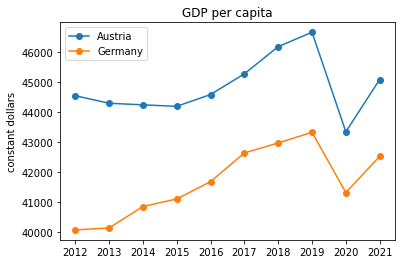

In [154]:
fig, ax = plt.subplots()
ax.plot(df.loc["Austria"].index, 
        df.loc["Austria", "NY.GDP.PCAP.KD"], 
        'o-', label="Austria")
ax.plot(df.loc["Germany"].index, 
        df.loc["Germany", "NY.GDP.PCAP.KD"], 
        'o-', label="Germany")

ax.legend()
ax.set_title("GDP per capita")
ax.set_ylabel("constant dollars");